## Loading the dataset

In [ ]:
! pip install -U datasets

In [1]:
from datasets import load_dataset
dataset = load_dataset("wikimedia/wikipedia", "20231101.en")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [3]:
import random
NO_OF_ARTICLES = 500000
length = len(dataset["train"])
random_indices = random.sample(range(length), NO_OF_ARTICLES)
articles = [dataset["train"][idx] for idx in random_indices]

In [4]:
articles = [x["text"] for x in articles]

In [5]:
import pandas as pd
df = pd.DataFrame({
    "articles" : articles
})

In [7]:
pattern = r'\b(?:player|team|score)\b'
sports_df = df[df['articles'].str.contains(pattern, case=False)].sample(frac=1)[:1000]
sports_df["category"] = "sports"
sports_df.shape

(1000, 2)

In [10]:
sports_df.head()

,articles,category
211872,"Team ""EuroStars"" is an Elite European Ultimate...",sports
476400,Alf Richard Bjercke (30 May 1921 – 9 December ...,sports
85840,Uncle Acid & the Deadbeats (written as Uncle A...,sports
371099,The 2009 G20 London summit protests occurred i...,sports
214926,"In clinical psychology, selective abstraction ...",sports


In [8]:
pattern = r'\b(?:theorem|proof|equation|formula)\b'
maths_df = df[df['articles'].str.contains(pattern, case=False)].sample(frac=1)[:1000]
maths_df["category"] = "mathematics"
maths_df.shape

(1000, 2)

In [9]:
maths_df.head()

,articles,category
228242,A high-pass filter (HPF) is an electronic filt...,mathematics
307476,The discharging method is a technique used to ...,mathematics
409048,"Gent–Wevelgem, officially Gent–Wevelgem – In F...",mathematics
43863,Chief Tom Ikimi (born 10 April 1944) in Kumba-...,mathematics
236007,Cornelius Franciscus de Pauw or Cornelis de Pa...,mathematics


In [11]:
pattern = r'\b(?:river|lake|ocean)\b'
geo_df = df[df['articles'].str.contains(pattern, case=False)].sample(frac=1)[:1000]
geo_df["category"] = "geography"
geo_df.shape

(1000, 2)

In [12]:
df = pd.concat([sports_df, maths_df, geo_df], axis=0).drop_duplicates().sample(frac=1)
df.shape

(3000, 2)

In [13]:
df.head()

,articles,category
104782,McGillivray Pass (1867 m or 6215 ft) is a moun...,geography
81132,"In cryptography, post-quantum cryptography (PQ...",mathematics
328041,Religious use of incense has its origins in an...,mathematics
340562,Edoardo Piscopo (born 4 February 1988) is an I...,sports
235560,The 1990s was the third decade in the industry...,mathematics


In [14]:
articles = df["articles"].tolist()

## Preprocessing

In [ ]:
# remove stop words
# remove punctuations
# change the articles to lower case

In [21]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words("english")

In [17]:
from tqdm import tqdm
for i, article in tqdm(enumerate(articles)):
    
    # remove punctuations
    PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~""" 
    article = ''.join([c for c in article if c not in PUNCTUATION])
    
    # remove the stop words and convert to lower case
    article = ' '.join([word for word in article.lower().split() if word not in stop and word.isalpha()])
    
    articles[i] = article
    

3000it [00:06, 468.71it/s]


## Vectorization

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")

In [19]:
articles_tfidf = vectorizer.fit_transform(articles)
articles_tfidf.shape

(3000, 23346)

### Implement Kmeans

In [195]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    n_clusters=3,
    n_init='auto'
)

In [196]:
label = kmeans.fit_predict(articles_tfidf)

In [197]:
len(label)

3000

In [198]:
kmeans.labels_

array([2, 2, 2, ..., 2, 1, 2])

### Visualization

In [199]:
feature_names = vectorizer.get_feature_names_out()

In [200]:
centroids = kmeans.cluster_centers_
top_n = 15
cluster_word_scores = {}
for i, centroid in enumerate(centroids):
    cluster_word_scores[i] = {}
    sorted_indices = centroid.argsort()[::-1]
    
    for idx in sorted_indices[:top_n]:
        word = feature_names[idx]
        score = centroid[idx]
        cluster_word_scores[i][word] = score

In [201]:
cluster_word_scores

{0: {'film': 0.04789511426594086,
  'formula': 0.04144094340139102,
  'films': 0.04105957446615522,
  'games': 0.03902798654117032,
  'championship': 0.038390893825919446,
  'racing': 0.03710356919216104,
  'race': 0.03420178518329332,
  'album': 0.032832336503109516,
  'drivers': 0.032764278094751555,
  'series': 0.03190374129076474,
  'team': 0.0275320129298744,
  'game': 0.026605584029959484,
  'world': 0.023901252278983594,
  'car': 0.022497898798974535,
  'video': 0.021505329620822314},
 1: {'players': 0.13957120692510133,
  'football': 0.09250637893189845,
  'league': 0.08146734905253149,
  'season': 0.06784490646600676,
  'mens': 0.05424239342873429,
  'team': 0.053024997116851234,
  'footballers': 0.0493360522921859,
  'club': 0.04780462812533029,
  'hockey': 0.04751451947823481,
  'fc': 0.04100005614637955,
  'played': 0.0403558071865716,
  'rugby': 0.03901768200809562,
  'cup': 0.03784149569900777,
  'basketball': 0.03266923850514679,
  'expatriate': 0.032651413695488046},
 2

In [ ]:
! pip install -U wordcloud

In [175]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [202]:
def plot_word_cloud(cluster_num, word_scores):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores)
    plt.figure(figsize=(8, 2))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster_num + 1} Word Cloud")
    plt.show()

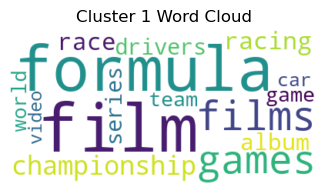

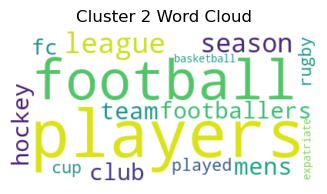

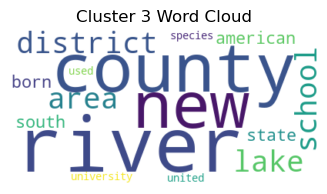

In [203]:
for cluster_idx, word_score in cluster_word_scores.items():
    plot_word_cloud(cluster_idx, word_score)